# To html
python -m nbconvert --to html research.ipynb

# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

df.head()

,symbol,timestamp,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,buy_trades_perp,total_trades_perp,spot_close,buy_volume_spot,total_volume_spot,buy_trades_spot,total_trades_spot,predicted_funding_rate,short_liquidation_volume,long_liquidation_volume
0,BTC,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,1.862977e+11,NaN,NaN,...,NaN,NaN,10381.18,10583.392061,23977.212617,99471.0,208843.0,NaN,NaN,NaN
1,BTC,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,1.854112e+11,NaN,NaN,...,NaN,NaN,10303.12,18729.472684,39835.727608,141490.0,289009.0,NaN,NaN,NaN
2,BTC,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,1.824183e+11,0.0003,NaN,...,NaN,NaN,10098.15,13430.583727,28911.844232,122732.0,251048.0,NaN,NaN,NaN
3,BTC,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,1.830630e+11,0.0003,NaN,...,NaN,NaN,10158.33,16580.247908,31946.418957,145852.0,270589.0,NaN,NaN,NaN
4,BTC,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,1.864050e+11,0.0003,NaN,...,4748.0,9848.0,10415.01,18529.736860,34461.558090,142940.0,271187.0,NaN,NaN,NaN


# Universe growth

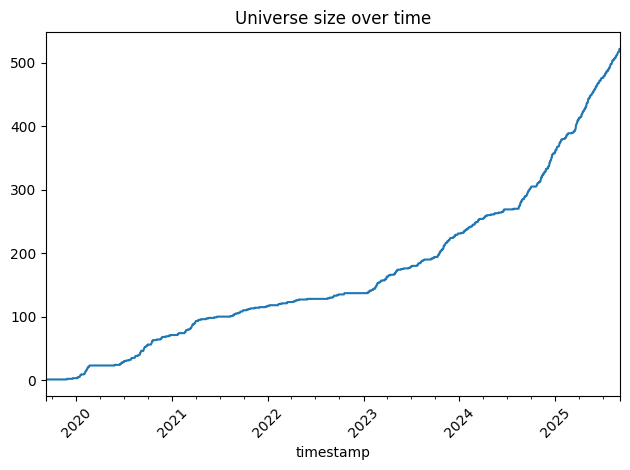

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

# Forward returns

In [3]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

df.sort_values('timestamp', inplace=True)

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# copy df to de-fragment it
df = df.copy()

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\3146204996.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\3146204996.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\3146204996.py:4: PerformanceWarning: DataFrame is 

Funding rate is important to consider in modelling

In [4]:
# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)
df.drop(columns=['vol_expanding_window', 'vol_ewm'], inplace=True)
df['volatility'] = df.groupby('symbol')['volatility'].shift(1)  # lag by 1 day to avoid lookahead bias


In [5]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = df.groupby('symbol')['dollar_volume'].transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())

df['dollar_volume_log'] = np.log1p(df['close'] * df['volume'])
df['dollar_volume_log_slowed'] = (
	df.groupby('symbol')['dollar_volume_log']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_log_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['dv_decile'] = df.groupby('timestamp')['dollar_volume_log_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1
df['dv_centile'] = df.groupby('timestamp')['dollar_volume_log_slowed'].transform(lambda x: pd.qcut(x, 100, labels=False, duplicates='drop')) + 1

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['mc_decile'] = df.groupby('timestamp')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

# days since listing
df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

# Compute signal

In [6]:
import signals

lookbacks = [1,2, 4, 8, 16, 32, 64, 128, 256]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df = signals._compute_ls_ratio(df, f'signal_{l}d', l)


Computing signal for lookback 1
Computing long–short ratio signal...
Computing signal for lookback 2
Computing long–short ratio signal...
Computing signal for lookback 4
Computing long–short ratio signal...
Computing signal for lookback 8
Computing long–short ratio signal...
Computing signal for lookback 16
Computing long–short ratio signal...
Computing signal for lookback 32
Computing long–short ratio signal...
Computing signal for lookback 64
Computing long–short ratio signal...
Computing signal for lookback 128
Computing long–short ratio signal...
Computing signal for lookback 256
Computing long–short ratio signal...


# Filter illiquids 

In [7]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume
df_filtered = df_filtered[df_filtered['days_since_listing'] >= 90] # at least 90 days since listing (need data for risk estimate)
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 371753 to 222845 rows


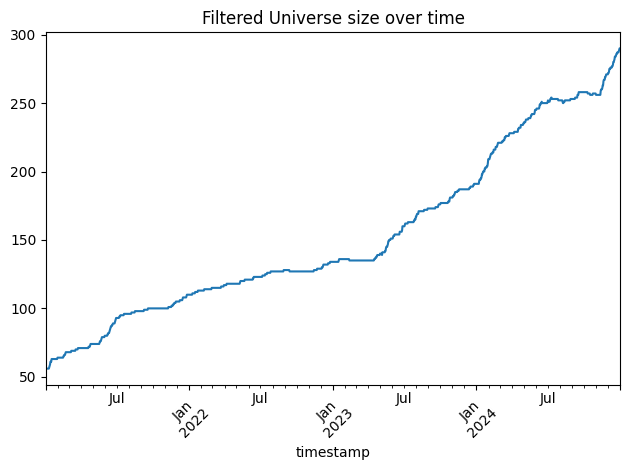

In [8]:
# plot universe size over time
df_filtered.groupby('timestamp').size().plot()
plt.title("Filtered Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

# Compute Factors 
Need not be orthogonal


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\3513328944.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['beta_raw'] = df_filtered.groupby('symbol', group_keys=False).apply(rolling_beta)


                     count          mean       std       min        1%  \
beta_score        216575.0 -2.309694e-17  1.000002 -6.317317 -3.285259   
vol_score         222845.0  4.081288e-18  1.000002 -4.361122 -2.009385   
dollar_vol_score  222845.0  8.162577e-18  1.000002 -9.348865 -1.799096   
momentum_score    222539.0  8.173801e-18  1.000002 -9.471611 -3.586001   
size_score        194052.0 -9.373721e-18  1.000003 -7.400652 -5.589877   

                        5%       25%       50%       75%       95%       99%  \
beta_score       -1.563047 -0.485852  0.026800  0.550340  1.443979  2.429435   
vol_score        -1.183727 -0.559111 -0.156254  0.360370  1.734238  3.630730   
dollar_vol_score -1.068931 -0.548199 -0.151485  0.467813  1.596433  3.200758   
momentum_score   -1.265362 -0.102805  0.030389  0.173159  0.973841  3.203230   
size_score       -0.661395 -0.240410  0.066554  0.393563  1.053894  1.925515   

                        max  
beta_score         7.215521  
vol_score     

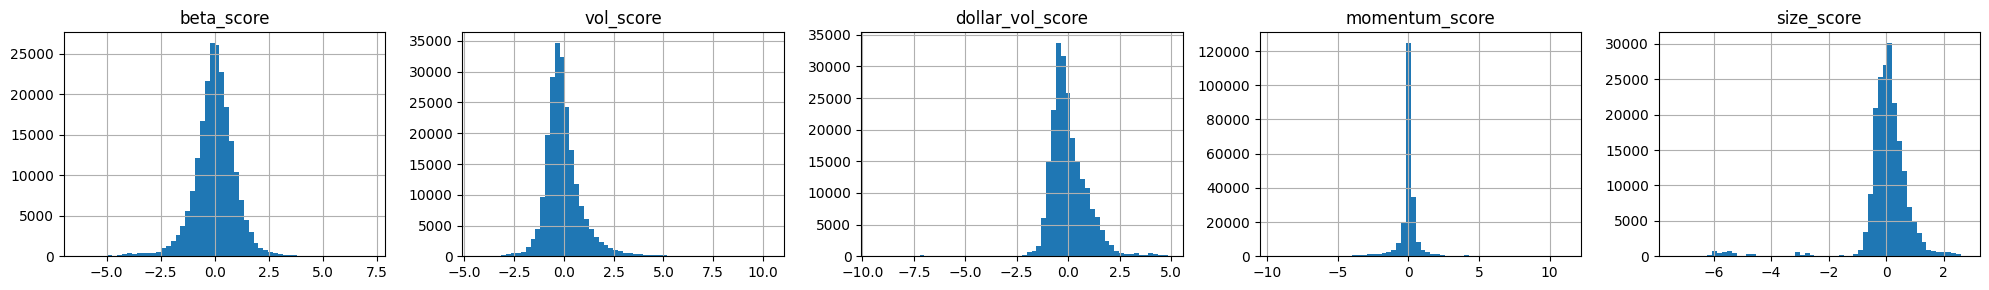

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helper ---
def cs_zscore_series(x: pd.Series) -> pd.Series:
    m, s = x.mean(), x.std(ddof=0)
    if not np.isfinite(s) or s == 0: 
        return x*0.0
    return (x - m) / s

df_filtered = df_filtered.sort_values(["symbol","timestamp"]).copy()

# --- base returns (for beta & momentum) ---
df_filtered['ret1d'] = df_filtered.groupby('symbol')['close'].pct_change()

# --- market return ---
mkt_ret = df_filtered.groupby('timestamp')['ret1d'].mean()
df_filtered['mkt_ret'] = df_filtered['timestamp'].map(mkt_ret)

# --- beta (60D rolling) ---
BETA_WIN = 60
def rolling_beta(g, win=BETA_WIN, minp=20):
    x, y = g['mkt_ret'], g['ret1d']
    mx = x.rolling(win, min_periods=minp).mean()
    my = y.rolling(win, min_periods=minp).mean()
    cov = (x*y).rolling(win, min_periods=minp).mean() - mx*my
    varx = (x*x).rolling(win, min_periods=minp).mean() - mx*mx
    return cov / varx.replace(0, np.nan)

df_filtered['beta_raw'] = df_filtered.groupby('symbol', group_keys=False).apply(rolling_beta)
df_filtered['beta_lag'] = df_filtered.groupby('symbol')['beta_raw'].shift(1)

# Momentum from 1-day log returns (Barras/AQR-style), no lookahead
MOM_HALFLIFE = 90  # tune (e.g., 42/63/90)
df_filtered['log_ret1d'] = np.log(df_filtered['close']).groupby(df_filtered['symbol']).diff()

df_filtered['mom_ewma'] = (
    df_filtered.groupby('symbol')['log_ret1d']
      .transform(lambda s: s.ewm(halflife=MOM_HALFLIFE, adjust=False, min_periods=1).mean())
      .shift(1)  # avoid overlap with today's move
)

# --- size (log mkt cap) ---
df_filtered['size_raw'] = np.log1p(df_filtered['mkt_cap'])

# --- cross-sectional z-scores ---
df_filtered['beta_score']        = df_filtered.groupby('timestamp')['beta_lag'].transform(cs_zscore_series)
df_filtered['vol_score']         = df_filtered.groupby('timestamp')['volatility'].transform(cs_zscore_series)
df_filtered['dollar_vol_score']  = df_filtered.groupby('timestamp')['dollar_volume_log_slowed'].transform(cs_zscore_series)
df_filtered['momentum_score']    = df_filtered.groupby('timestamp')['mom_ewma'].transform(cs_zscore_series)
df_filtered['size_score']        = df_filtered.groupby('timestamp')['size_raw'].transform(cs_zscore_series)

# --- distributions ---
score_cols = ['beta_score','vol_score','dollar_vol_score','momentum_score','size_score']
summary = df_filtered[score_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
print(summary[['count','mean','std','min','1%','5%','25%','50%','75%','95%','99%','max']])

# --- optional plots ---
fig, axes = plt.subplots(1, len(score_cols), figsize=(20, 3))
for ax, col in zip(axes, score_cols):
    df_filtered[col].dropna().hist(bins=60, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [10]:

factor_cols = ['beta_score','vol_score','dollar_vol_score','momentum_score']

# ffill factors
# df_filtered = df_filtered.sort_values(['symbol','timestamp']).copy()
# for col in factor_cols:
#     df_filtered[col] = df_filtered.groupby('symbol')[col].ffill()

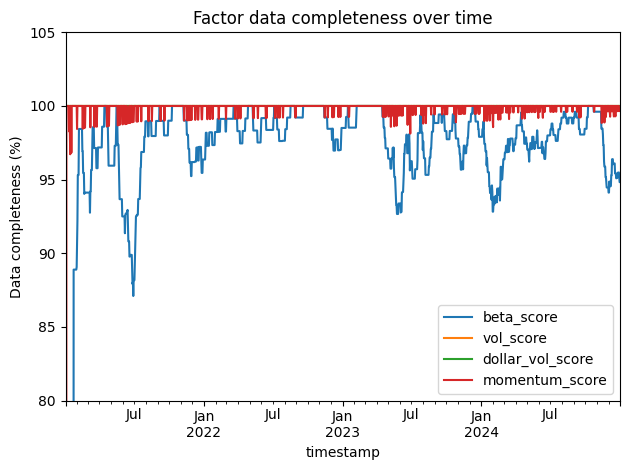

In [11]:
# plot data completeness percent of factor columns

for col in factor_cols:
    completeness = df_filtered.groupby('timestamp')[col].apply(lambda x: x.notna().mean() * 100)
    completeness.plot(label=col)
plt.ylabel("Data completeness (%)")
plt.title("Factor data completeness over time")
plt.legend()
plt.ylim(80, 105)
plt.tight_layout()

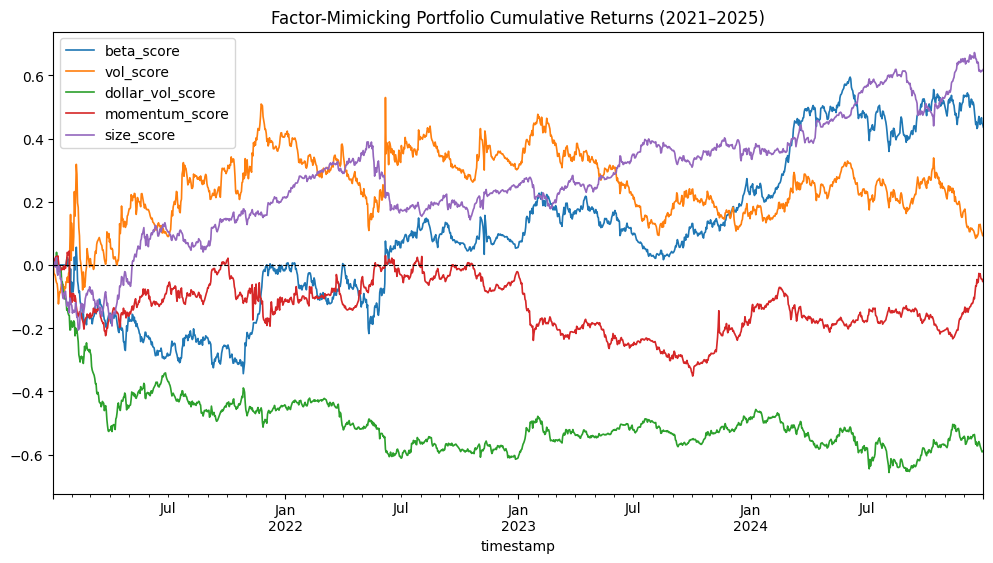

In [12]:
import numpy as np
import pandas as pd

def make_fmp(df, factor_col, ret_col="ret1d", investable_col=None,
             neutralize_cols=None, winsor_q=0.05):
    """
    Build a factor-mimicking portfolio (FMP) for `factor_col`.
    - Dollar-neutral by construction (demean cross-section)
    - Gross = 1 via L1 normalization
    - Optional: neutralize weights to other factors (size/beta/vol, etc.)
    - Optional: restrict to investable universe (boolean column)
    Returns: (weights_df, factor_return_series)
    """
    g = df.copy()

    # restrict to investable, if provided
    if investable_col is not None:
        g = g[g[investable_col]]

    # keep only what's needed
    cols = ["timestamp", "symbol", factor_col, ret_col]
    if neutralize_cols:
        cols += neutralize_cols
    g = g[cols].dropna(subset=["timestamp", "symbol", factor_col, ret_col])

    # (optional) winsorize factor per day for stability
    def winsor(x):
        if len(x) == 0:
            return x
        lo, hi = x.quantile([winsor_q, 1 - winsor_q])
        return x.clip(lo, hi)

    # per-day weights
    w_list = []
    for t, gt in g.groupby("timestamp"):
        f = winsor(gt[factor_col])

        # neutralize to other factors if requested (intercept included)
        if neutralize_cols and len(neutralize_cols) > 0:
            Z = np.column_stack([np.ones(len(gt))] + [gt[c].values for c in neutralize_cols])
            beta, *_ = np.linalg.lstsq(Z, f.values, rcond=None)
            f_ortho = f.values - Z @ beta
            f_use = pd.Series(f_ortho, index=gt.index)
        else:
            f_use = f

        # demean and L1-normalize → dollar-neutral, gross=1
        f_dm = f_use - f_use.mean()
        denom = np.abs(f_dm).sum()
        if denom == 0 or not np.isfinite(denom):
            w = pd.Series(0.0, index=gt.index)
        else:
            w = f_dm / denom

        w_list.append(pd.DataFrame({"timestamp": t, "symbol": gt["symbol"].values, "w": w.values}))

    W = pd.concat(w_list, ignore_index=True)

    # factor return: use *next-period* realized returns with lagged weights
    # pivot for calc (align by timestamp)
    R = g.pivot(index="timestamp", columns="symbol", values=ret_col).sort_index()
    Wp = W.pivot(index="timestamp", columns="symbol", values="w").reindex(R.index).fillna(0.0)

    # traded weights are lagged by 1 day
    fmp_ret = (Wp.shift().fillna(0.0) * R).sum(axis=1)

    return Wp, fmp_ret

# Example usage (no neutralization, whole universe):
import matplotlib.pyplot as plt

score_cols = ['beta_score','vol_score','dollar_vol_score','momentum_score','size_score']

# make sure returns exist
if "ret1d" not in df_filtered.columns:
    df_filtered["ret1d"] = df_filtered.groupby("symbol")["close"].pct_change()

# restrict sample
df_sub = df_filtered[df_filtered["timestamp"].between("2021-01-01", "2024-12-31")]

factor_rets = {}
for col in score_cols:
    # demeaned weights each day, scale to 1 gross
    df_sub["w"] = df_sub.groupby("timestamp")[col] \
        .transform(lambda x: (x - x.mean()) / (x - x.mean()).abs().sum())

    # daily factor return = sum of w * asset return
    daily_ret = (df_sub["w"] * df_sub["ret1d"]).groupby(df_sub["timestamp"]).sum()
    factor_rets[col] = daily_ret

# combine into one DataFrame
factor_rets = pd.DataFrame(factor_rets)

# filter to 2024
factor_rets = factor_rets.loc["2021-01-01":"2024-12-31"]

# cumulative returns
cumrets = factor_rets.cumsum()

cumrets.plot(figsize=(12,6), lw=1.2)
plt.title("Factor-Mimicking Portfolio Cumulative Returns (2021–2025)")
plt.axhline(0, color='k', ls='--', lw=0.8)
plt.legend(loc="best")
plt.show()



In [13]:
factor_rets.mean() / factor_rets.std() * np.sqrt(365)  # annualized Sharpe

beta_score          0.399355
vol_score           0.063070
dollar_vol_score   -0.904324
momentum_score     -0.059452
size_score          0.856883
dtype: float64

# Calculate idio returns and signals

In [14]:
# Demean forward returns cross-sectionally (by timestamp) (this is your target)
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

for col in combined_cols:
    means = df_filtered.groupby("timestamp")[col].transform("mean")
    new_col = f"{col}_demeaned"
    df_filtered[new_col] = df_filtered[col] - means

df_filtered = df_filtered.copy() # de-fragment

In [15]:
import numpy as np
import pandas as pd

# CONFIG
factor_cols  = ['beta_score','vol_score','dollar_vol_score','momentum_score']
signal_cols  = [f'signal_{n}d' for n in [1,2,4,8,16,32,64,128,256]]  # add more if you have them, e.g. ['signal_a','signal_b']
ret_col      = 'fwd_combined_return_10d_demeaned'  # or whatever you’re using
investable_col = None  # e.g., 'investable' (bool) if you want to restrict the cross-section

import numpy as np
import pandas as pd

def residualize_panel(df, factor_cols, signal_cols, ret_col,
                      investable_col=None, min_obs=None):
    """
    Per-day residualization:
      - Fit on rows with finite factors AND finite y (per y).
      - Write residuals for those rows; leave the rest NaN.
      - No global row dropping; preserves daily coverage for names with data.
    """
    out = []
    cols = ['timestamp','symbol'] + factor_cols + signal_cols + [ret_col]
    gdf = df[cols].copy()

    if investable_col is not None and investable_col in df.columns:
        gdf = gdf[gdf[investable_col]]

    p = len(factor_cols) + 1  # intercept + factors
    min_needed = max(p, 8) if min_obs is None else max(p, min_obs)

    for t, g in gdf.groupby('timestamp', sort=False):
        row = g[['timestamp','symbol']].copy()

        # Build factor matrix (with intercept) for the whole group
        F = np.column_stack([np.ones(len(g))] + [g[c].to_numpy(dtype=float) for c in factor_cols])
        F_ok = np.isfinite(F).all(axis=1)

        def resid_arr(y_arr):
            yv = np.asarray(y_arr, dtype=float)
            ok = F_ok & np.isfinite(yv)
            r = np.full(len(g), np.nan, dtype=float)
            if ok.sum() >= min_needed:
                b, *_ = np.linalg.lstsq(F[ok], yv[ok], rcond=None)
                r[ok] = yv[ok] - F[ok] @ b
            return r

        # signals
        for s in signal_cols:
            row[f"{s}_id"] = resid_arr(g[s].to_numpy())

        # forward return
        if ret_col in g.columns:
            row[f"{ret_col}_id"] = resid_arr(g[ret_col].to_numpy())

        out.append(row)

    return pd.concat(out, ignore_index=True)


# --- run it ---
id_df = residualize_panel(df_filtered, factor_cols, signal_cols, ret_col, investable_col)

# merge idiosyncratic columns back
df_filtered = df_filtered.merge(id_df, on=['timestamp','symbol'], how='left')

# sanity checks: exposures of idio signal to factors ≈ 0 each day
for s in signal_cols:
    name = f'{s}_id'
    check = df_filtered.groupby('timestamp').apply(
        lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1] 
                             / (x[f].fillna(0).var(ddof=0) if x[f].var(ddof=0) else np.nan)
                             for f in factor_cols})
    )
    print(f'\nMean daily exposure of {name} to factors (should be ~0):')
    print(check.mean(numeric_only=True))


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_1d_id to factors (should be ~0):
exp_beta_score         -6.181880e-18
exp_vol_score          -6.187948e-19
exp_dollar_vol_score    5.557673e-17
exp_momentum_score      3.483058e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_2d_id to factors (should be ~0):
exp_beta_score         -1.181839e-17
exp_vol_score          -5.382459e-18
exp_dollar_vol_score    5.298799e-17
exp_momentum_score      3.646881e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_4d_id to factors (should be ~0):
exp_beta_score          4.885123e-18
exp_vol_score           2.272973e-18
exp_dollar_vol_score    6.276036e-17
exp_momentum_score      4.046417e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_8d_id to factors (should be ~0):
exp_beta_score         -6.931554e-18
exp_vol_score          -1.644953e-20
exp_dollar_vol_score    6.621656e-17
exp_momentum_score      3.239838e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(



Mean daily exposure of signal_16d_id to factors (should be ~0):
exp_beta_score         -2.056496e-18
exp_vol_score           3.655311e-18
exp_dollar_vol_score    6.418790e-17
exp_momentum_score      2.495869e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_32d_id to factors (should be ~0):
exp_beta_score         -8.929741e-18
exp_vol_score           6.795996e-18
exp_dollar_vol_score    6.951538e-17
exp_momentum_score      2.614099e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_64d_id to factors (should be ~0):
exp_beta_score         -6.371297e-18
exp_vol_score           9.742222e-18
exp_dollar_vol_score    5.769574e-17
exp_momentum_score      2.068259e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: pd.Series({f'exp_{f}': np.cov(x[name].fillna(0), x[f].fillna(0))[0,1]



Mean daily exposure of signal_128d_id to factors (should be ~0):
exp_beta_score          6.168787e-18
exp_vol_score           1.825918e-17
exp_dollar_vol_score    4.949940e-17
exp_momentum_score      1.892655e-17
dtype: float64

Mean daily exposure of signal_256d_id to factors (should be ~0):
exp_beta_score         -5.167087e-18
exp_vol_score           4.509146e-18
exp_dollar_vol_score    3.983958e-17
exp_momentum_score      2.645379e-17
dtype: float64


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_4712\4203311870.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  check = df_filtered.groupby('timestamp').apply(


# Visualize signals

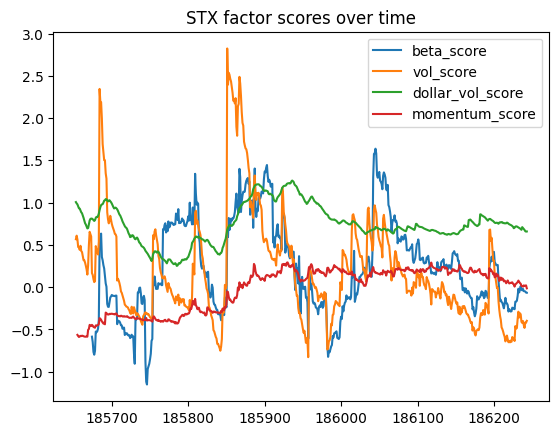

idio vol: 2.5370399335185967
full vol: 2.602390495858446


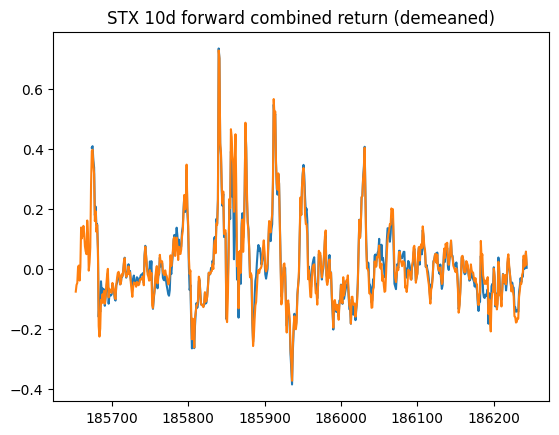

In [ ]:
symbol = "STX"
coin = df_filtered[df_filtered['symbol'] == symbol].copy()
coin[factor_cols].plot(title=f'{symbol} factor scores over time')
plt.show()
coin['fwd_combined_return_10d_demeaned_id'].plot(title=f'{symbol} idiosyncratic 10d forward combined return (demeaned)')
coin['fwd_combined_return_10d_demeaned'].plot(title=f'{symbol} 10d forward combined return (demeaned)')

# idio vol vs full vol
print(f"idio vol: {coin['fwd_combined_return_10d_demeaned_id'].std()*np.sqrt(365)}")
print(f"full vol: {coin['fwd_combined_return_10d_demeaned'].std()*np.sqrt(365)}")


# it berely reduces vol??

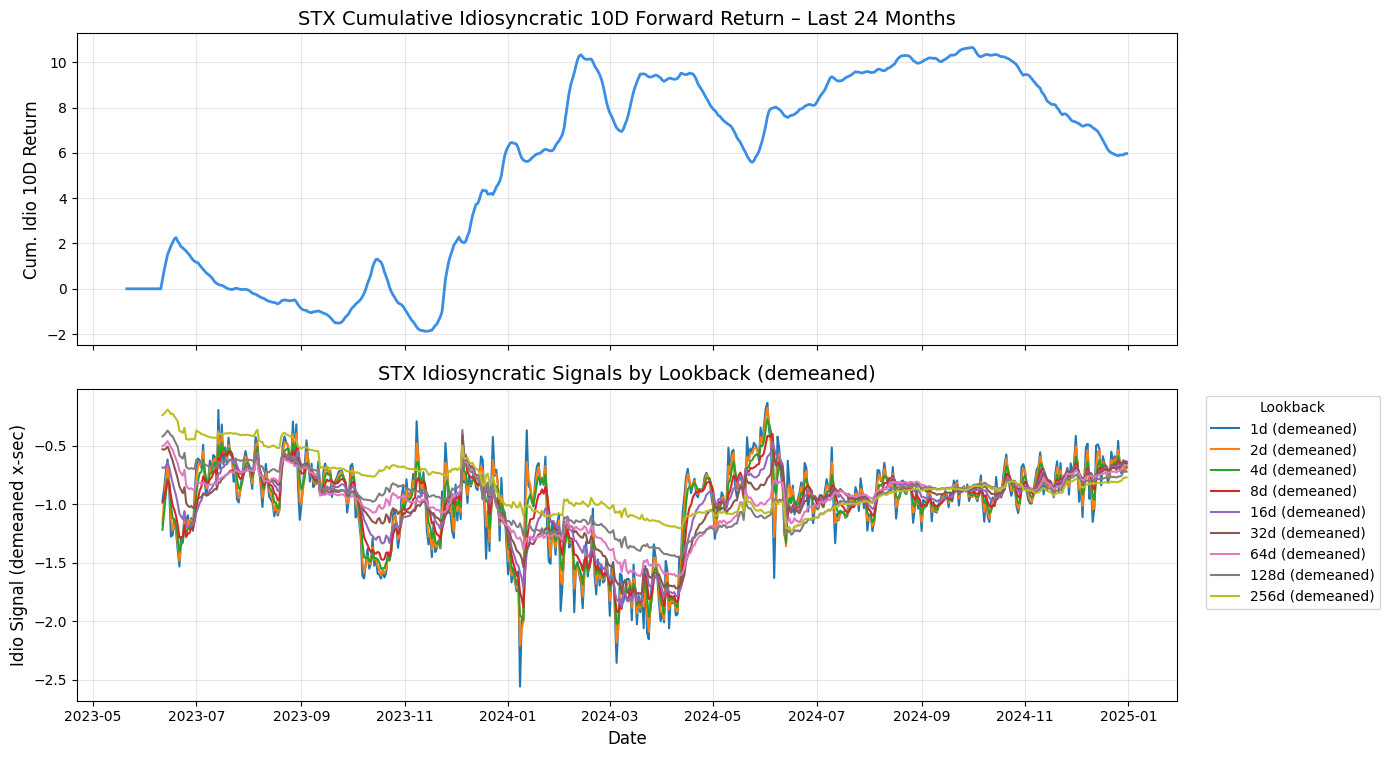

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --- build cross-sectional demeaned idio signals (do this once) ---
for l in lookbacks:
    col = f"signal_{l}d_id"
    if col in df_filtered.columns:
        df_filtered[f"{col}_dm"] = df_filtered.groupby("timestamp")[col].transform(lambda x: x - x.mean())

# --- STX slice, last 24 months ----------------------------
coin = "STX"
avax = df_filtered[df_filtered['symbol'] == coin].copy()
avax['timestamp'] = pd.to_datetime(avax['timestamp'])
end   = avax['timestamp'].max()
start = end - pd.DateOffset(months=24)
avax  = avax[avax['timestamp'] >= start]

# --- cumulated idio forward return --------------------------
avax["cum_idio_ret10d"] = avax["fwd_combined_return_10d_demeaned_id"].fillna(0).cumsum()

# --- plot: idio cum return (top) vs demeaned idio signal (bottom) ---
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(14, 8),
    gridspec_kw={"height_ratios": [1, 1]}
)

# Top: cumulative idio forward return
ax1.plot(avax['timestamp'], avax['cum_idio_ret10d'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Cum. Idio 10D Return', fontsize=12)
ax1.set_title(f'{coin} Cumulative Idiosyncratic 10D Forward Return – Last 24 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: cross-sectionally demeaned idio signals
for l in lookbacks:
    col_dm = f"signal_{l}d_id_dm"
    if col_dm in avax.columns:
        ax2.plot(avax['timestamp'], avax[col_dm], lw=1.5, label=f'{l}d (demeaned)')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Idio Signal (demeaned x-sec)', fontsize=12)
ax2.set_title(f'{coin} Idiosyncratic Signals by Lookback (demeaned)', fontsize=14)
ax2.legend(title='Lookback', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

1
2
4
8
16
32
64
128
256


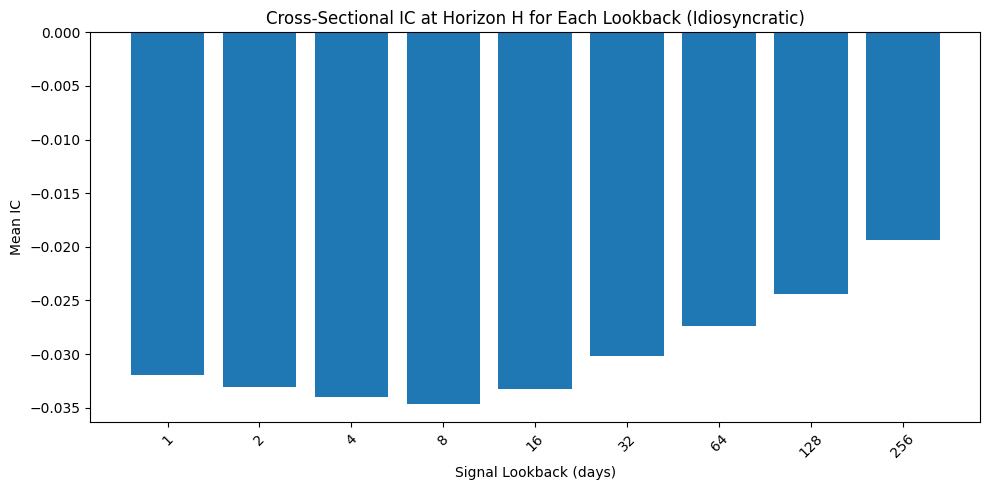

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
1             0.433558       2.306497         10 -0.031983
2             0.289476       3.454512         10 -0.033060
4             0.188318       5.310174         10 -0.034029
8             0.121850       8.206787         10 -0.034605
16            0.080687      12.393586         10 -0.033295
32            0.056251      17.777305         10 -0.030188
64            0.042422      23.572690         10 -0.027344
128           0.034981      28.587236         10 -0.024397
256           0.031528      31.717627         10 -0.019340


In [18]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d_id_dm"  # idio demeaned signal
	ret_col = "fwd_combined_return_10d_demeaned_id"  # idio demeaned forward return

	# 1) build the raw signal matrix, with NaNs for missing symbols
	S = df_filtered.pivot(index="timestamp", columns="symbol", values=sig_col)

	# 2) subtract the cross-sectional mean (should already be demeaned, but keep for safety)
	S0 = S.sub(S.mean(axis=1), axis=0)

	# 3) normalize by sum of abs deviations
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# 4) put missing positions back to 0
	W = W.fillna(0)

	# 5) turnover
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn = daily_turnover.mean()
	avg_hold = 1.0 / avg_turn
	H = 10  # int(round(avg_hold))

	# 6) horizon-matched IC
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback (Idiosyncratic)")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


# IC heatmap by dv_decile/lookback

Computing IC for lookback 1
Computing IC for lookback 2
Computing IC for lookback 4
Computing IC for lookback 8
Computing IC for lookback 16
Computing IC for lookback 32
Computing IC for lookback 64
Computing IC for lookback 128
Computing IC for lookback 256


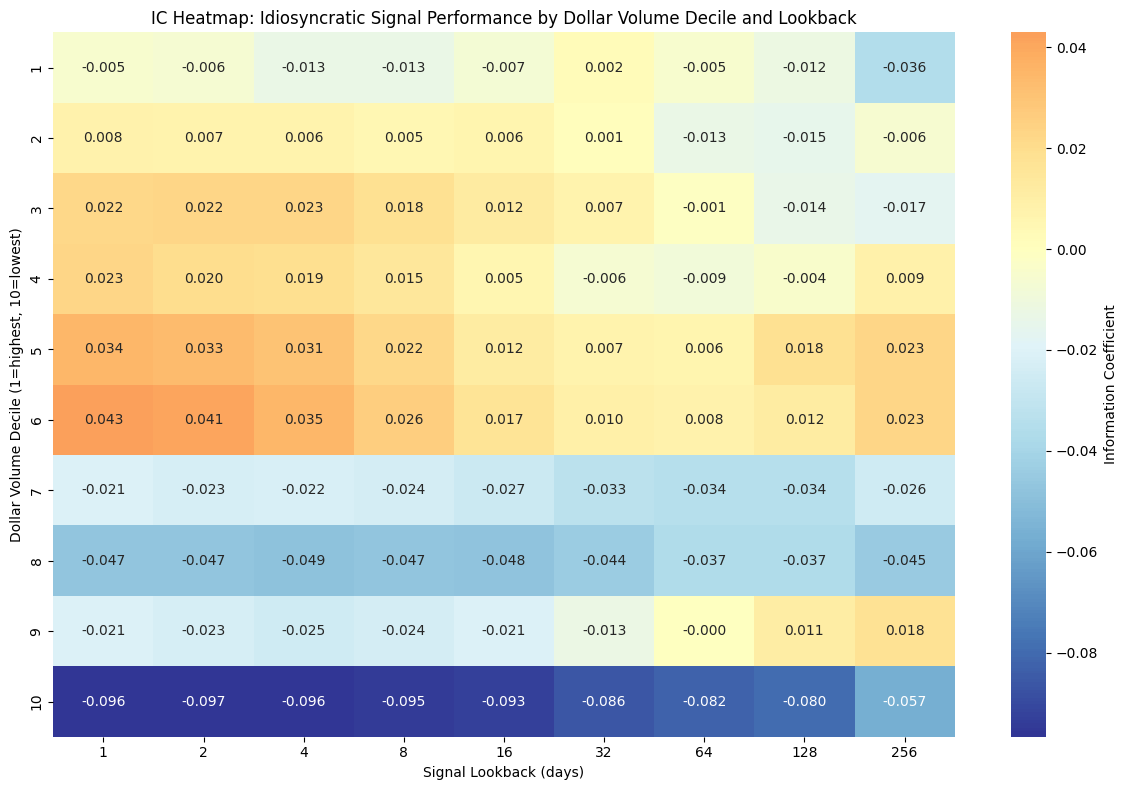


IC Summary by Decile:
dv_decile
1    -0.010461
2    -0.000081
3     0.007867
4     0.007956
5     0.020718
6     0.023800
7    -0.026955
8    -0.044589
9    -0.010784
10   -0.086899
dtype: float64

IC Summary by Lookback:
lookback
1     -0.006021
2     -0.007229
4     -0.009121
8     -0.011644
16    -0.014378
32    -0.015480
64    -0.016785
128   -0.015426
256   -0.011400
dtype: float64


In [19]:
# IC heatmap by dv_decile/lookback (idiosyncratic)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ic_heatmap_data = []

for l in lookbacks:
    print(f"Computing IC for lookback {l}")
    sig_col = f"signal_{l}d_id"
    ret_col = "fwd_combined_return_10d_demeaned_id"  # idio demeaned forward return

    for decile in range(1, 11):  # dv_deciles 1-10
        decile_data = df_filtered[df_filtered['dv_decile'] == decile]

        if len(decile_data) > 10:
            daily_ics = (
                decile_data
                .groupby("timestamp")[[sig_col, ret_col]]
                .apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2, method="spearman") if len(g) >= 2 else np.nan)
                .dropna()
            )
            ic_mean = daily_ics.mean() if len(daily_ics) > 0 else np.nan
        else:
            ic_mean = np.nan

        ic_heatmap_data.append({
            'lookback': l,
            'dv_decile': decile,
            'IC': ic_mean
        })

ic_df = pd.DataFrame(ic_heatmap_data)
ic_pivot = ic_df.pivot(index='dv_decile', columns='lookback', values='IC')

plt.figure(figsize=(12, 8))
sns.heatmap(
    ic_pivot,
    annot=True,
    fmt='.3f',
    cmap='RdYlBu_r',
    center=0,
    cbar_kws={'label': 'Information Coefficient'}
)
plt.title('IC Heatmap: Idiosyncratic Signal Performance by Dollar Volume Decile and Lookback')
plt.xlabel('Signal Lookback (days)')
plt.ylabel('Dollar Volume Decile (1=highest, 10=lowest)')
plt.tight_layout()
plt.show()

print("\nIC Summary by Decile:")
print(ic_pivot.mean(axis=1).sort_index())
print("\nIC Summary by Lookback:")
print(ic_pivot.mean(axis=0))


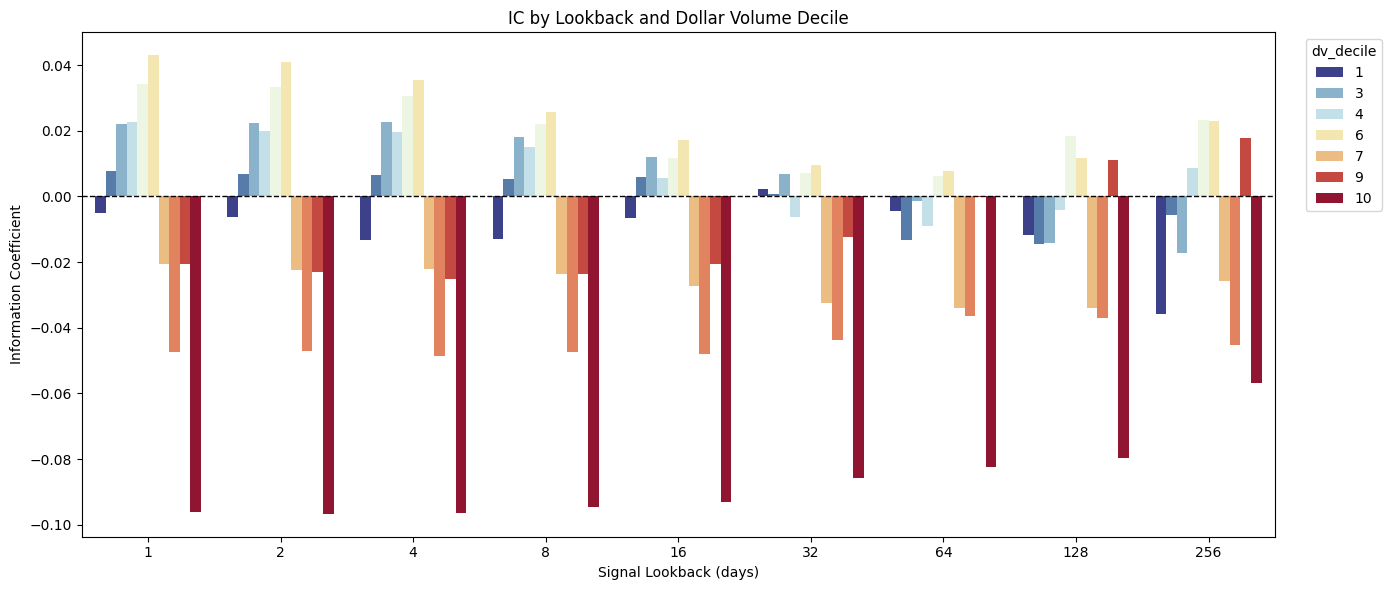

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the pivoted table for plotting
ic_long = ic_pivot.reset_index().melt(id_vars="dv_decile", var_name="lookback", value_name="IC")

plt.figure(figsize=(14, 6))
sns.barplot(
    data=ic_long,
    x="lookback",
    y="IC",
    hue="dv_decile",
    palette="RdYlBu_r"
)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("IC by Lookback and Dollar Volume Decile")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Information Coefficient")
plt.legend(title="dv_decile", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Signal Selection

In [21]:
df_filtered['signal'] = df_filtered['signal_32d_id']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [22]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 18.48


# Signal distribution

Five-number summary:
  Min     : -4.1677
  25th %ile: -0.4662
  Median  : -0.0723
  75th %ile: 0.3900
  Max     : 8.4594


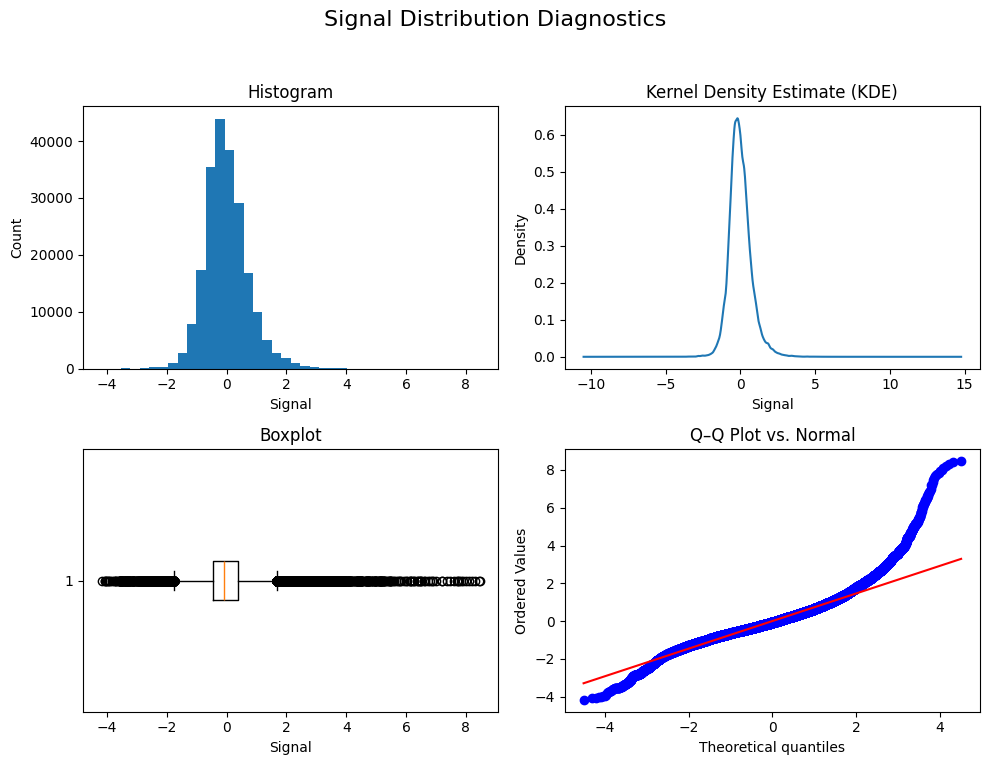

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Performance by ADV decile

Mean daily IC by dv_decile:
1.0     0.002245
2.0     0.000822
3.0     0.006689
4.0    -0.006362
5.0     0.006982
6.0     0.009626
7.0    -0.032599
8.0    -0.043806
9.0    -0.012521
10.0   -0.085881
dtype: float64


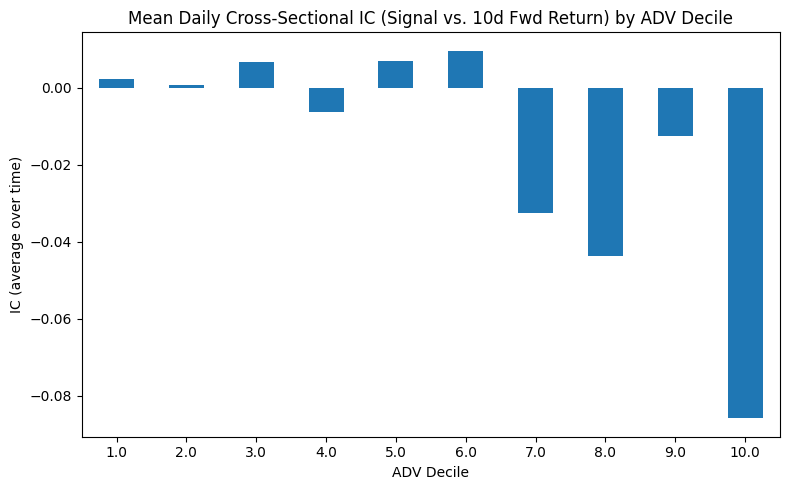

In [24]:
# Method 1: cross-sectional IC averaged over time, by dv_decile
import pandas as pd
import matplotlib.pyplot as plt

ic_by_decile = {}

target = "fwd_combined_return_10d_demeaned_id"

for decile, g in df_filtered.groupby("dv_decile"):
    # For each day in this decile, compute cross-sectional correlation
    daily_ic = (
        g.groupby("timestamp")[["signal", target]]
            .apply(lambda x: x["signal"].corr(x[target], min_periods=2, method = "spearman") if len(x) >= 2 else None)
            .dropna()
    )
    if len(daily_ic) > 0:
        ic_by_decile[decile] = daily_ic.mean()
    else:
        ic_by_decile[decile] = float("nan")

# Convert to Series for plotting
ic_series = pd.Series(ic_by_decile).sort_index()

print("Mean daily IC by dv_decile:")
print(ic_series)

# Plot
ic_series.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Daily Cross-Sectional IC (Signal vs. 10d Fwd Return) by ADV Decile')
plt.xlabel('ADV Decile')
plt.ylabel('IC (average over time)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Regressions by adv decile

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_13936\2402852390.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_13936\2402852390.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)
C:\Users\itataurov.KORECAP

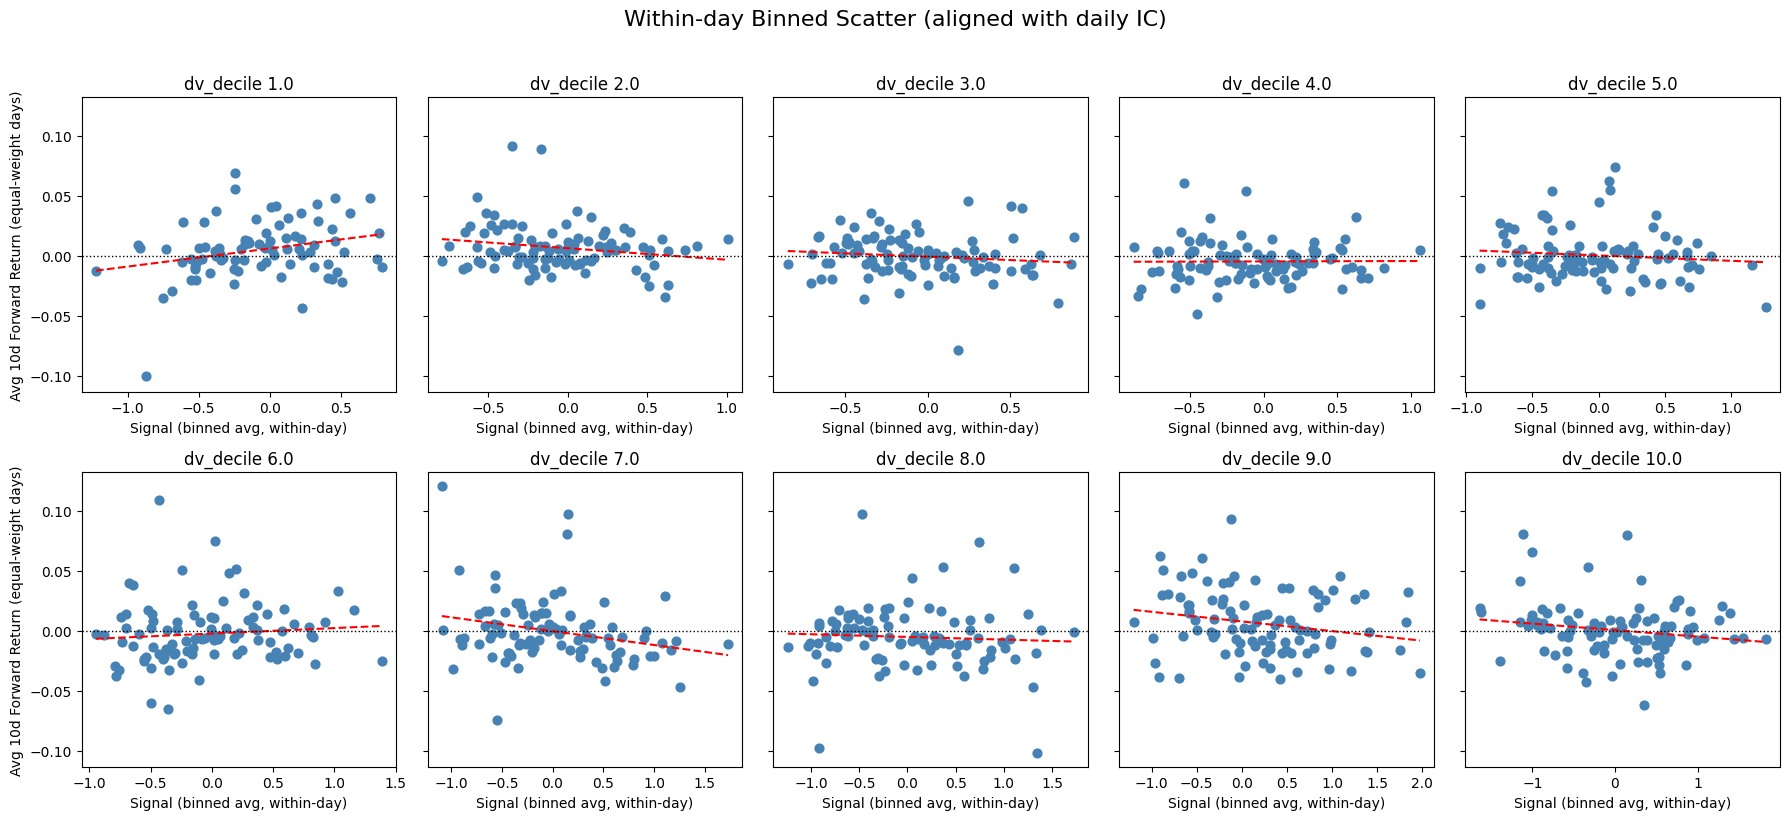

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

target = "fwd_combined_return_10d_demeaned_id"
signal_col = "signal"
n_bins = 100

# Set up subplots grid (2 rows x 5 cols = 10 panels)
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for i, decile in enumerate(sorted(df_filtered['dv_decile'].unique())):
    ax = axes[i]
    g = df_filtered.loc[df_filtered['dv_decile'] == decile,
                        ['timestamp', signal_col, target]].dropna()
    if g.empty:
        ax.set_title(f"Decile {decile} (no data)")
        continue

    # --- bin signals WITHIN each day ---
    def bin_within_day(df):
        df['signal_bin'] = pd.qcut(df[signal_col], n_bins,
                                   labels=False, duplicates="drop")
        return df

    g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)

    # --- per-day bin averages ---
    per_day_bin_means = (
        g.groupby(['timestamp', 'signal_bin'])[[signal_col, target]]
         .mean()
         .reset_index()
    )

    # --- now average over days (equal-weight) ---
    bin_means = per_day_bin_means.groupby('signal_bin')[[signal_col, target]].mean()

    # Scatter plot: binned signal vs avg fwd return
    ax.scatter(bin_means[signal_col], bin_means[target],
               s=40, color="steelblue")

    # Fit linear regression line through the bins
    X = bin_means[[signal_col]].values
    y = bin_means[target].values
    if len(bin_means) > 1:
        reg = LinearRegression().fit(X, y)
        x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_line = reg.predict(x_line)
        ax.plot(x_line, y_line, color="red", linestyle="--")

    ax.axhline(0, color="black", linewidth=1, linestyle=":")
    ax.set_title(f"dv_decile {decile}")
    ax.set_xlabel("Signal (binned avg, within-day)")
    if i % 5 == 0:
        ax.set_ylabel("Avg 10d Forward Return (equal-weight days)")

plt.suptitle("Within-day Binned Scatter (aligned with daily IC)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Create our single forecast

In [26]:
df = df_filtered.copy()

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- config ----------------
df = df[df.timestamp<'2025-01-01'].sort_values(["timestamp","symbol"]).copy()
H = 10
target_col = "fwd_combined_return_10d_demeaned_id"
adv_col = "size_score"

factor_cols = [adv_col, "beta_score", "vol_score", "dollar_vol_score", "momentum_score"]
factor_cols_unique = list(dict.fromkeys(factor_cols))  # dedupe, preserve order

df["timestamp64"] = df["timestamp"].to_numpy(dtype="datetime64[ns]")
df["forecast"] = np.nan
dates = np.sort(df["timestamp"].unique())

# --------------- helpers ----------------
def cs_residual(y, F, min_obs=None, eps=1e-8):
    """
    Residual of y on [1, F] for a single cross-section.
    Robust to NaNs/ill-conditioning; returns a vector aligned to F's index.
    """
    A = np.column_stack([np.ones(len(F))] + [F[c].to_numpy(dtype=float) for c in F.columns])
    yv = np.asarray(y, dtype=float)

    ok = np.isfinite(yv) & np.isfinite(A).all(axis=1)
    r = np.full(len(yv), np.nan, dtype=float)

    p = A.shape[1]
    need = max(p + 1, 8) if min_obs is None else max(p, min_obs)
    if ok.sum() < need:
        return r

    A0 = A[ok].copy()
    y0 = yv[ok].copy()

    # center non-intercept cols (helps conditioning)
    A0[:, 1:] -= A0[:, 1:].mean(axis=0)

    try:
        b, *_ = np.linalg.lstsq(A0, y0, rcond=None)
    except np.linalg.LinAlgError:
        AtA = A0.T @ A0
        b = np.linalg.pinv(AtA + eps * np.eye(p)) @ (A0.T @ y0)

    if not np.all(np.isfinite(b)):
        AtA = A0.T @ A0
        b = np.linalg.pinv(AtA + eps * np.eye(p)) @ (A0.T @ y0)

    r[ok] = y0 - A0 @ b
    return r


def compute_vif(X):
    v = []
    for j in range(X.shape[1]):
        yj = X[:, j]
        Xj = np.delete(X, j, axis=1)
        b, *_ = np.linalg.lstsq(Xj, yj, rcond=None)
        r = yj - Xj @ b
        if np.var(yj) == 0:
            r2 = 0.0
        else:
            r2 = 1 - np.sum(r*r) / np.sum((yj - yj.mean())**2)
        v.append(np.inf if r2 >= 1 else 1/(1-r2))
    return v

# --------------- precompute residuals ----------------
rows = []
for t, g in df.groupby("timestamp", sort=False):
    F = g[factor_cols_unique]
    s = g["signal"].to_numpy()
    z = g[adv_col].to_numpy()
    rows.append(pd.DataFrame({
        "s_perp": cs_residual(s, F),
        "j_perp": cs_residual(s*z, F)
    }, index=g.index))

df[["s_perp", "j_perp"]] = pd.concat(rows).sort_index()

# --------------- training/testing loop ----------------
betas, vif_list = [], []

need = [target_col, "signal", adv_col] + factor_cols_unique
valid = df[need].notna().all(axis=1)

for d in dates:
    cutoff = np.datetime64(pd.Timestamp(d) - pd.Timedelta(days=H))
    tr_mask = (df["timestamp64"] <= cutoff) & valid
    if tr_mask.sum() < 100:
        continue

    start_date = df.loc[tr_mask, "timestamp"].min()
    end_date   = df.loc[tr_mask, "timestamp"].max()
    print(f"Processing {d}, training window from {start_date} to {end_date}.")

    # training set
    X_tr = df.loc[tr_mask, ["s_perp","j_perp"]].to_numpy()
    y_tr = df.loc[tr_mask, target_col].to_numpy()

    mu, sd = X_tr.mean(axis=0), X_tr.std(axis=0, ddof=0)
    sd[sd==0] = 1
    X_tr = (X_tr - mu) / sd
    X_tr = np.column_stack([np.ones(len(X_tr)), X_tr])

    b, *_ = np.linalg.lstsq(X_tr, y_tr, rcond=None)

    # store VIF
    vifs = compute_vif(X_tr[:,1:])
    vif_list.append({"date": d, "s_perp": vifs[0], "j_perp": vifs[1]})

    # test set
    te_mask = df["timestamp"] == d
    if te_mask.any():
        X_te = df.loc[te_mask, ["s_perp","j_perp"]].to_numpy()
        X_te = (X_te - mu) / sd
        X_te = np.column_stack([np.ones(len(X_te)), X_te])
        df.loc[te_mask, "forecast"] = X_te @ b

    betas.append({"date": d, "const": b[0], "s_perp": b[1], "j_perp": b[2]})

# --------------- outputs ----------------
betas_df = pd.DataFrame(betas).set_index("date")
vif_df   = pd.DataFrame(vif_list).set_index("date")


Processing 2021-02-03T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-24 00:00:00.
Processing 2021-02-04T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-25 00:00:00.
Processing 2021-02-05T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-26 00:00:00.
Processing 2021-02-06T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-27 00:00:00.
Processing 2021-02-07T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-28 00:00:00.
Processing 2021-02-08T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-29 00:00:00.
Processing 2021-02-09T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-30 00:00:00.
Processing 2021-02-10T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-01-31 00:00:00.
Processing 2021-02-11T00:00:00.000000000, training window from 2021-01-23 00:00:00 to 2021-02-01 00:00:00.
Processing 2021-02-12T00:00:00.000000

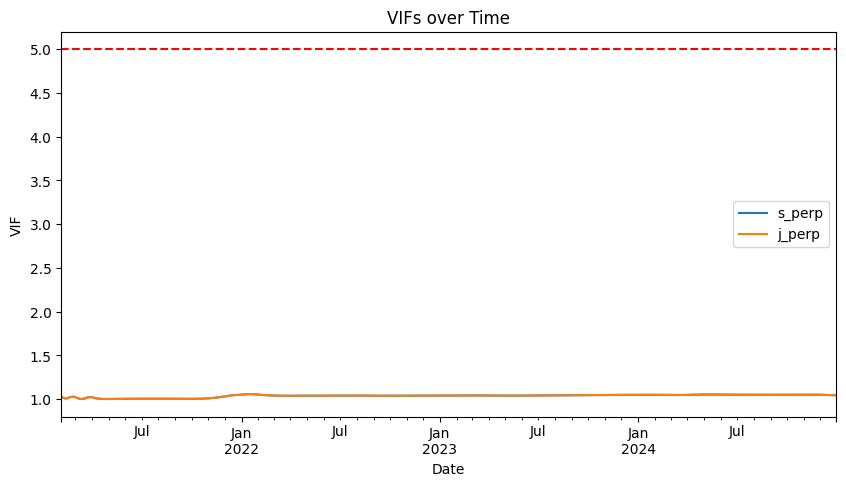

In [34]:
# plot vif
vif_df.plot(figsize=(10, 5))
plt.title("VIFs over Time")
plt.ylabel("VIF")
plt.xlabel("Date")
plt.axhline(5, color='red', linestyle='--', label='VIF=5 Threshold')

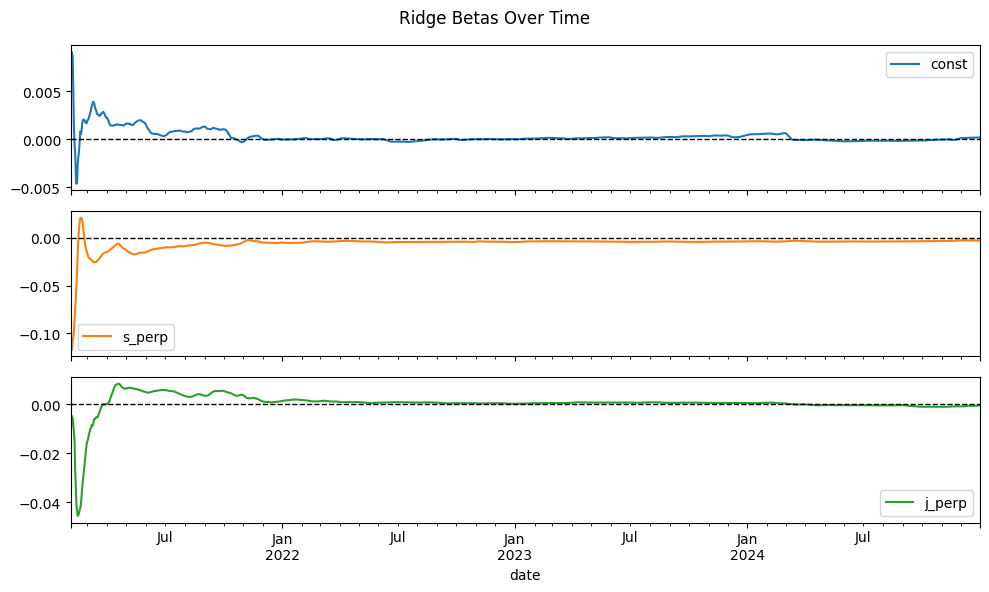

In [35]:
# convert tracking results
betas_df = pd.DataFrame(betas).set_index("date")

# plot betas
betas_df.plot(subplots=True, figsize=(10,6), title="Ridge Betas Over Time")
# horiz lines at 0
for ax in plt.gcf().axes:
    ax.axhline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()


# Decay

C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_13936\3298818050.py:51: RuntimeWarning: Mean of empty slice
  decay[H] = np.nanmean(daily_vals) if daily_vals else np.nan


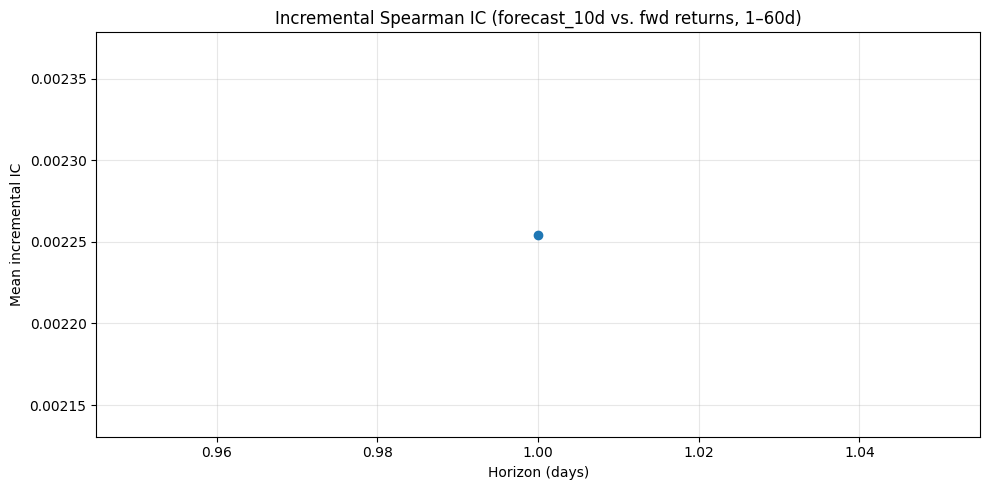

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup ---
horizons = np.arange(1, 61)
rets = {h: df[f"fwd_combined_return_10d_demeaned_id"].to_numpy() for h in horizons}
fcast = df["forecast"].to_numpy()
timestamps = df["timestamp"].to_numpy()

# Precompute row indices per day (so we don't re-scan)
day_to_idx = {}
for i, d in enumerate(timestamps):
    day_to_idx.setdefault(d, []).append(i)

# Convert lists to NumPy arrays for speed
for d in day_to_idx:
    day_to_idx[d] = np.array(day_to_idx[d], dtype=int)

# --- Function to compute cross-sectional Spearman fast ---
from scipy.stats import rankdata

def daily_spearman(x, y):
    # rankdata assigns average ranks, handles ties
    rx = rankdata(x)
    ry = rankdata(y)
    return np.corrcoef(rx, ry)[0,1]

# --- Incremental IC per horizon ---
decay = {}

for i, H in enumerate(horizons):
    if i == 0:
        inc_ret = rets[H]
    else:
        inc_ret = rets[H] - rets[horizons[i-1]]

    daily_vals = []
    for d, idxs in day_to_idx.items():
        if len(idxs) < 2:
            continue
        x = fcast[idxs]
        y = inc_ret[idxs]
        if np.all(np.isnan(y)) or np.all(np.isnan(x)):
            continue
        mask = (~np.isnan(x)) & (~np.isnan(y))
        if mask.sum() < 2:
            continue
        daily_vals.append(daily_spearman(x[mask], y[mask]))

    decay[H] = np.nanmean(daily_vals) if daily_vals else np.nan

decay_series = pd.Series(decay)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(decay_series.index, decay_series.values, marker='o')
plt.title("Incremental Spearman IC (forecast_10d vs. fwd returns, 1–60d)")
plt.xlabel("Horizon (days)")
plt.ylabel("Mean incremental IC")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Signal stability over time

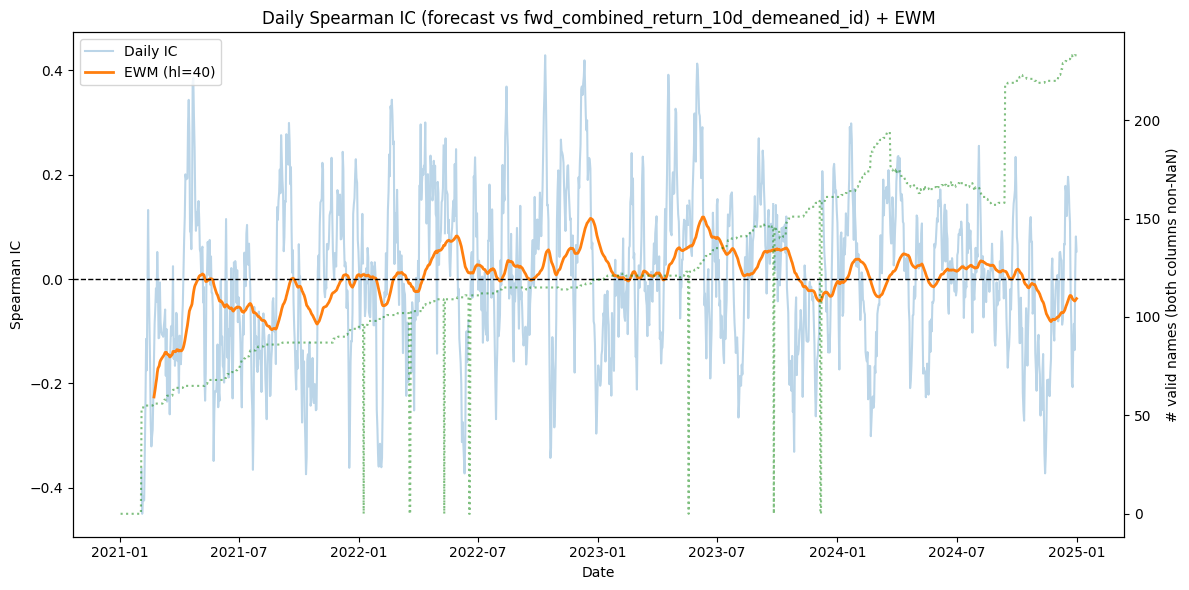

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata

ret_col = "fwd_combined_return_10d_demeaned_id"

# All dates present in the panel
all_dates = np.sort(df["timestamp"].unique())

# Precompute row indices per date (fast, avoids repeated groupby)
idx_map = df.groupby("timestamp", sort=True).indices

# Count valid pairs per date (both forecast & return non-NaN)
valid_pair = df[["forecast", ret_col]].notna().all(axis=1)
valid_pairs_per_day = pd.Series(valid_pair, index=df.index).groupby(df["timestamp"]).sum()
valid_pairs_per_day = valid_pairs_per_day.reindex(all_dates, fill_value=0)

def cs_spearman_for_idxs(idxs: np.ndarray) -> float:
    x = df["forecast"].to_numpy()[idxs]
    y = df[ret_col].to_numpy()[idxs]
    m = (~np.isnan(x)) & (~np.isnan(y))
    if m.sum() < 2:
        return np.nan
    rx = rankdata(x[m])
    ry = rankdata(y[m])
    return float(np.corrcoef(rx, ry)[0, 1])

# Daily IC series over ALL dates (NaNs kept instead of dropped)
ics_daily = pd.Series(index=all_dates, dtype=float)
for d in all_dates:
    idxs = np.asarray(idx_map.get(d, []), dtype=int)
    ics_daily.loc[d] = cs_spearman_for_idxs(idxs)

# Smooth with EWM (tune halflife/min_periods as you like)
ics_ewm = ics_daily.ewm(halflife=40, min_periods=20).mean()

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(ics_daily.index, ics_daily.values, alpha=0.3, label="Daily IC")
ax1.plot(ics_ewm.index, ics_ewm.values, linewidth=2, label="EWM (hl=40)")
ax1.axhline(0, color="black", lw=1, ls="--")
ax1.set_title(f"Daily Spearman IC (forecast vs {ret_col}) + EWM")
ax1.set_xlabel("Date")
ax1.set_ylabel("Spearman IC")
ax1.legend(loc="upper left")

# Overlay valid pair counts (helps explain stops)
ax2 = ax1.twinx()
ax2.plot(valid_pairs_per_day.index, valid_pairs_per_day.values, ls=":", alpha=0.5, color="green")
ax2.set_ylabel("# valid names (both columns non-NaN)")

plt.tight_layout()
plt.show()


# Systematic LS backtest

# Factor exposures (Should be ~0 due to gram-schmidt procedure)

Sharpe for forecast: 0.53
Vol: 13.41%


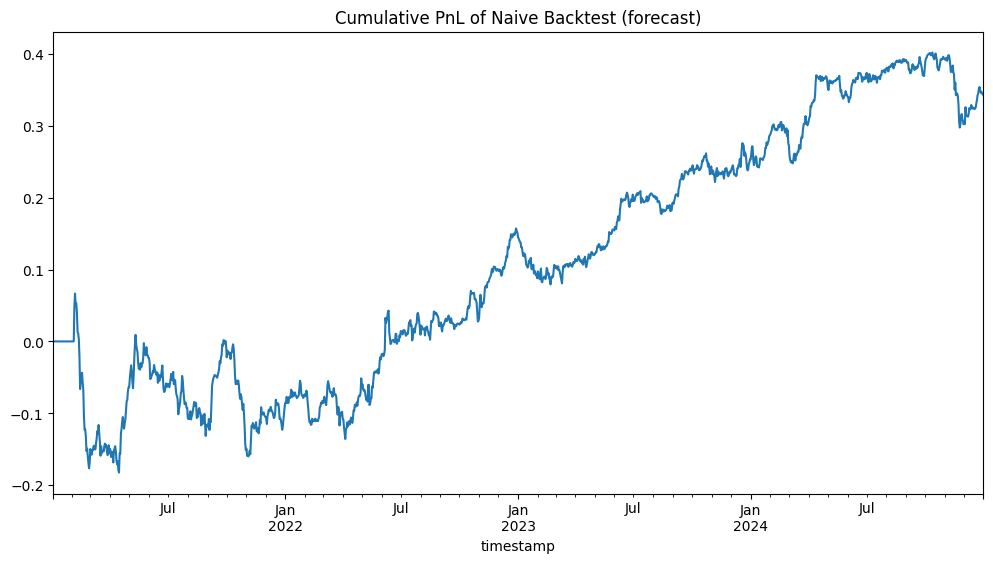

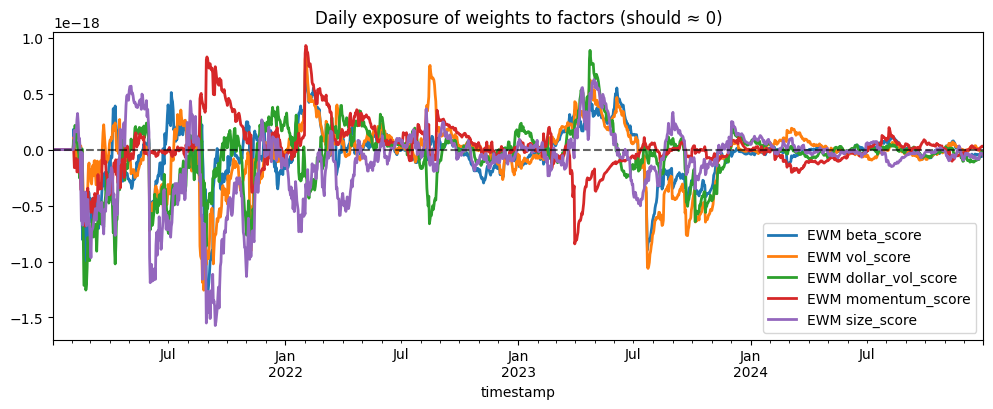

In [38]:
# Backtest with neutrality checks for all factors in score_cols
forecasts = ["forecast"]
for forecast_name in forecasts:
    df_bt = df[['timestamp', 'symbol', forecast_name, 'close'] + score_cols].copy()
    df_bt['return'] = df_bt.groupby('symbol')['close'].pct_change()

    # cross-sectionally demean forecasts, scale to 1 gross
    df_bt['position'] = df_bt.groupby('timestamp')[forecast_name] \
        .transform(lambda x: (x - x.mean()) / (x - x.mean()).abs().sum())

    # wide pivots
    W = df_bt.pivot(values='position', columns='symbol', index='timestamp')
    R = df_bt.pivot(values='return', columns='symbol', index='timestamp')
    factor_pivots = {f: df_bt.pivot(values=f, columns='symbol', index='timestamp') for f in score_cols}

    # --- PnL ---
    P = (W.shift() * R).sum(axis=1).fillna(0)
    P.cumsum().plot(figsize=(12,6))
    plt.title(f"Cumulative PnL of Naive Backtest ({forecast_name})")
    print(f"Sharpe for {forecast_name}: {P.mean()/P.std()*np.sqrt(252):.2f}")
    print(f"Vol: {P.std()*np.sqrt(365):.2%}")

    # --- Neutrality checks ---
    factor_centered = {f: F.sub(F.mean(axis=1), axis=0) for f, F in factor_pivots.items()}
    common = W.columns
    for f in score_cols:
        factor_centered[f] = factor_centered[f][common]

    exposures = {}
    for f in score_cols:
        Wc = W[common]
        Fc = factor_centered[f]
        exposures[f] = (Wc * Fc).sum(axis=1) / (Fc.pow(2)).sum(axis=1).replace(0, np.nan)

    fig, ax = plt.subplots(figsize=(12, 4))
    for f in score_cols:
        # exposures[f].plot(ax=ax, lw=0.9, label=f"exp to {f}")
        exposures[f].ewm(halflife=20).mean().plot(ax=ax, lw=2, label=f"EWM {f}")
    ax.axhline(0, color='k', ls='--', alpha=0.6)
    ax.set_title("Daily exposure of weights to factors (should ≈ 0)")
    ax.legend()
